In [ ]:
http://gbeced.github.io/pyalgotrade/docs/v0.20/html/samples.html#samples-label

# VWAP Momentum Trade (work)

In [26]:
from __future__ import print_function

from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.technical import vwap
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import drawdown
import matplotlib.pyplot as plt
import pyfolio as pf

class VWAPMomentum(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, vwapWindowSize, threshold):
        super(VWAPMomentum, self).__init__(feed)
        self.__instrument = instrument
        self.__vwap = vwap.VWAP(feed[instrument], vwapWindowSize)
        self.__threshold = threshold

    def getVWAP(self):
        return self.__vwap

    def onBars(self, bars):
        vwap = self.__vwap[-1]
        if vwap is None:
            return

        shares = self.getBroker().getShares(self.__instrument)
        price = bars[self.__instrument].getClose()
        notional = shares * price

        if price > vwap * (1 + self.__threshold) and notional < 1000000:
            self.marketOrder(self.__instrument, 100)
        elif price < vwap * (1 - self.__threshold) and notional > 0:
            self.marketOrder(self.__instrument, -100)


def main(plot):
    instrument = "NFLX"
    vwapWindowSize = 5
    threshold = 0.01

    # Download the bars.
    feed = quandl.build_feed("WIKI", [instrument], 2011, 2015, ".")

    strat = VWAPMomentum(feed, instrument, vwapWindowSize, threshold)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    returnsAnalyzer = returns.Returns()
    drawdownAnalyzer = drawdown.DrawDown()
    strat.attachAnalyzer(sharpeRatioAnalyzer)
    strat.attachAnalyzer(returnsAnalyzer)
    strat.attachAnalyzer(drawdownAnalyzer)

    

    if plot:
        plt = plotter.StrategyPlotter(strat, True, False, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("vwap", strat.getVWAP())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))
    print("returns: %.2f" % returnsAnalyzer.getReturns(1000))
    print("drawdown: %.2f" % drawdownAnalyzer.getDrawDown(0.05))
    plt.plot()


if __name__ == "__main__":
    main(True)


Sharpe ratio: 0.06


TypeError: getReturns() takes 1 positional argument but 2 were given

In [25]:
help(returns.Returns())

Help on Returns in module pyalgotrade.stratanalyzer.returns object:

class Returns(pyalgotrade.stratanalyzer.StrategyAnalyzer)
 |  Returns(maxLen=None)
 |  
 |  A :class:`pyalgotrade.stratanalyzer.StrategyAnalyzer` that calculates time-weighted returns for the
 |  whole portfolio.
 |  
 |  :param maxLen: The maximum number of values to hold in net and cumulative returs dataseries.
 |      Once a bounded length is full, when new items are added, a corresponding number of items are discarded from the
 |      opposite end. If None then dataseries.DEFAULT_MAX_LEN is used.
 |  :type maxLen: int.
 |  
 |  Method resolution order:
 |      Returns
 |      pyalgotrade.stratanalyzer.StrategyAnalyzer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, maxLen=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  beforeAttach(self, strat)
 |  
 |  getCumulativeReturns(self)
 |      Returns a :class:`pyalgotrade.dataseries.DataSeries` with t

In [8]:
pf.create_full_tear_sheet(Portfolio.mean(axis=1))

NameError: name 'Portfolio' is not defined

# SMA Crossover (work)

In [2]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross


class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(SMACrossOver, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        # We'll use adjusted close values instead of regular close values.
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                # Enter a buy market order. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, shares, True)
        # Check if we have to exit the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.__position.exitMarket()

Sharpe ratio: 1.12


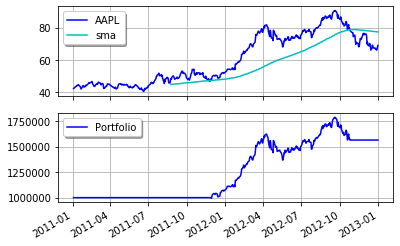

In [3]:
from __future__ import print_function


from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.stratanalyzer import sharpe


def main(plot):
    instrument = "AAPL"
    smaPeriod = 163

    # Download the bars.
    feed = quandl.build_feed("WIKI", [instrument], 2011, 2012, ".")

    strat = SMACrossOver(feed, instrument, smaPeriod)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, True, False, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("sma", strat.getSMA())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

# Market Timing Using Moving-Average Crossovers (doesn't work)

In [4]:
from __future__ import print_function

from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade.technical import cumret
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import returns


class MarketTiming(strategy.BacktestingStrategy):
    def __init__(self, feed, instrumentsByClass, initialCash):
        super(MarketTiming, self).__init__(feed, initialCash)
        self.setUseAdjustedValues(True)
        self.__instrumentsByClass = instrumentsByClass
        self.__rebalanceMonth = None
        self.__sharesToBuy = {}
        # Initialize indicators for each instrument.
        self.__sma = {}
        for assetClass in instrumentsByClass:
            for instrument in instrumentsByClass[assetClass]:
                priceDS = feed[instrument].getPriceDataSeries()
                self.__sma[instrument] = ma.SMA(priceDS, 200)

    def _shouldRebalance(self, dateTime):
        return dateTime.month != self.__rebalanceMonth

    def _getRank(self, instrument):
        # If the price is below the SMA, then this instrument doesn't rank at
        # all.
        smas = self.__sma[instrument]
        price = self.getLastPrice(instrument)
        if len(smas) == 0 or smas[-1] is None or price < smas[-1]:
            return None

        # Rank based on 20 day returns.
        ret = None
        lookBack = 20
        priceDS = self.getFeed()[instrument].getPriceDataSeries()
        if len(priceDS) >= lookBack and smas[-1] is not None and smas[-1*lookBack] is not None:
            ret = (priceDS[-1] - priceDS[-1*lookBack]) / float(priceDS[-1*lookBack])
        return ret

    def _getTopByClass(self, assetClass):
        # Find the instrument with the highest rank.
        ret = None
        highestRank = None
        for instrument in self.__instrumentsByClass[assetClass]:
            rank = self._getRank(instrument)
            if rank is not None and (highestRank is None or rank > highestRank):
                highestRank = rank
                ret = instrument
        return ret

    def _getTop(self):
        ret = {}
        for assetClass in self.__instrumentsByClass:
            ret[assetClass] = self._getTopByClass(assetClass)
        return ret

    def _placePendingOrders(self):
        # Use less chash just in case price changes too much.
        remainingCash = round(self.getBroker().getCash() * 0.9, 2)

        for instrument in self.__sharesToBuy:
            orderSize = self.__sharesToBuy[instrument]
            if orderSize > 0:
                # Adjust the order size based on available cash.
                lastPrice = self.getLastPrice(instrument)
                cost = orderSize * lastPrice
                while cost > remainingCash and orderSize > 0:
                    orderSize -= 1
                    cost = orderSize * lastPrice
                if orderSize > 0:
                    remainingCash -= cost
                    assert(remainingCash >= 0)

            if orderSize != 0:
                self.info("Placing market order for %d %s shares" % (orderSize, instrument))
                self.marketOrder(instrument, orderSize, goodTillCanceled=True)
                self.__sharesToBuy[instrument] -= orderSize

    def _logPosSize(self):
        totalEquity = self.getBroker().getEquity()
        positions = self.getBroker().getPositions()
        for instrument in self.getBroker().getPositions():
            posSize = positions[instrument] * self.getLastPrice(instrument) / totalEquity * 100
            self.info("%s - %0.2f %%" % (instrument, posSize))

    def _rebalance(self):
        self.info("Rebalancing")

        # Cancel all active/pending orders.
        for order in self.getBroker().getActiveOrders():
            self.getBroker().cancelOrder(order)

        cashPerAssetClass = round(self.getBroker().getEquity() / float(len(self.__instrumentsByClass)), 2)
        self.__sharesToBuy = {}

        # Calculate which positions should be open during the next period.
        topByClass = self._getTop()
        for assetClass in topByClass:
            instrument = topByClass[assetClass]
            self.info("Best for class %s: %s" % (assetClass, instrument))
            if instrument is not None:
                lastPrice = self.getLastPrice(instrument)
                cashForInstrument = round(cashPerAssetClass - self.getBroker().getShares(instrument) * lastPrice, 2)
                # This may yield a negative value and we have to reduce this
                # position.
                self.__sharesToBuy[instrument] = int(cashForInstrument / lastPrice)

        # Calculate which positions should be closed.
        for instrument in self.getBroker().getPositions():
            if instrument not in topByClass.values():
                currentShares = self.getBroker().getShares(instrument)
                assert(instrument not in self.__sharesToBuy)
                self.__sharesToBuy[instrument] = currentShares * -1

    def getSMA(self, instrument):
        return self.__sma[instrument]

    def onBars(self, bars):
        currentDateTime = bars.getDateTime()

        if self._shouldRebalance(currentDateTime):
            self.__rebalanceMonth = currentDateTime.month
            self._rebalance()

        self._placePendingOrders()


def main(plot):
    initialCash = 10000
    instrumentsByClass = {
        "US Stocks": ["VTI"],
        "Foreign Stocks": ["VEU"],
        "US 10 Year Government Bonds": ["IEF"],
        "Real Estate": ["VNQ"],
        "Commodities": ["DBC"],
    }

    # Load the bars. These files were manually downloaded from Yahoo Finance.
    feed = yahoofeed.Feed()
    instruments = ["SPY"]
    for assetClass in instrumentsByClass:
        instruments.extend(instrumentsByClass[assetClass])

    for year in range(2007, 2013+1):
        for instrument in instruments:
            fileName = "%s-%d-yahoofinance.csv" % (instrument, year)
            print("Loading bars from %s" % fileName)
            feed.addBarsFromCSV(instrument, fileName)

    # Build the strategy and attach some metrics.
    strat = MarketTiming(feed, instrumentsByClass, initialCash)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)
    returnsAnalyzer = returns.Returns()
    strat.attachAnalyzer(returnsAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, False, False, True)
        plt.getOrCreateSubplot("cash").addCallback("Cash", lambda x: strat.getBroker().getCash())
        # Plot strategy vs. SPY cumulative returns.
        plt.getOrCreateSubplot("returns").addDataSeries("SPY", cumret.CumulativeReturn(feed["SPY"].getPriceDataSeries()))
        plt.getOrCreateSubplot("returns").addDataSeries("Strategy", returnsAnalyzer.getCumulativeReturns())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))
    print("Returns: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

Loading bars from SPY-2007-yahoofinance.csv


FileNotFoundError: [Errno 2] No such file or directory: 'SPY-2007-yahoofinance.csv'

# Ernie Chan’s Gold vs. Gold Miners (doesn't work)

In [ ]:
from __future__ import print_function

from pyalgotrade import strategy
from pyalgotrade import dataseries
from pyalgotrade.dataseries import aligned
from pyalgotrade import plotter
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.stratanalyzer import sharpe

import numpy as np
import statsmodels.api as sm


def get_beta(values1, values2):
    # http://statsmodels.sourceforge.net/stable/regression.html
    model = sm.OLS(values1, values2)
    results = model.fit()
    return results.params[0]


class StatArbHelper:
    def __init__(self, ds1, ds2, windowSize):
        # We're going to use datetime aligned versions of the dataseries.
        self.__ds1, self.__ds2 = aligned.datetime_aligned(ds1, ds2)
        self.__windowSize = windowSize
        self.__hedgeRatio = None
        self.__spread = None
        self.__spreadMean = None
        self.__spreadStd = None
        self.__zScore = None

    def getSpread(self):
        return self.__spread

    def getSpreadMean(self):
        return self.__spreadMean

    def getSpreadStd(self):
        return self.__spreadStd

    def getZScore(self):
        return self.__zScore

    def getHedgeRatio(self):
        return self.__hedgeRatio

    def __updateHedgeRatio(self, values1, values2):
        self.__hedgeRatio = get_beta(values1, values2)

    def __updateSpreadMeanAndStd(self, values1, values2):
        if self.__hedgeRatio is not None:
            spread = values1 - values2 * self.__hedgeRatio
            self.__spreadMean = spread.mean()
            self.__spreadStd = spread.std(ddof=1)

    def __updateSpread(self):
        if self.__hedgeRatio is not None:
            self.__spread = self.__ds1[-1] - self.__hedgeRatio * self.__ds2[-1]

    def __updateZScore(self):
        if self.__spread is not None and self.__spreadMean is not None and self.__spreadStd is not None:
            self.__zScore = (self.__spread - self.__spreadMean) / float(self.__spreadStd)

    def update(self):
        if len(self.__ds1) >= self.__windowSize:
            values1 = np.asarray(self.__ds1[-1*self.__windowSize:])
            values2 = np.asarray(self.__ds2[-1*self.__windowSize:])
            self.__updateHedgeRatio(values1, values2)
            self.__updateSpread()
            self.__updateSpreadMeanAndStd(values1, values2)
            self.__updateZScore()


class StatArb(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument1, instrument2, windowSize):
        super(StatArb, self).__init__(feed)
        self.setUseAdjustedValues(True)
        self.__statArbHelper = StatArbHelper(feed[instrument1].getAdjCloseDataSeries(), feed[instrument2].getAdjCloseDataSeries(), windowSize)
        self.__i1 = instrument1
        self.__i2 = instrument2

        # These are used only for plotting purposes.
        self.__spread = dataseries.SequenceDataSeries()
        self.__hedgeRatio = dataseries.SequenceDataSeries()

    def getSpreadDS(self):
        return self.__spread

    def getHedgeRatioDS(self):
        return self.__hedgeRatio

    def __getOrderSize(self, bars, hedgeRatio):
        cash = self.getBroker().getCash(False)
        price1 = bars[self.__i1].getAdjClose()
        price2 = bars[self.__i2].getAdjClose()
        size1 = int(cash / (price1 + hedgeRatio * price2))
        size2 = int(size1 * hedgeRatio)
        return (size1, size2)

    def buySpread(self, bars, hedgeRatio):
        amount1, amount2 = self.__getOrderSize(bars, hedgeRatio)
        self.marketOrder(self.__i1, amount1)
        self.marketOrder(self.__i2, amount2 * -1)

    def sellSpread(self, bars, hedgeRatio):
        amount1, amount2 = self.__getOrderSize(bars, hedgeRatio)
        self.marketOrder(self.__i1, amount1 * -1)
        self.marketOrder(self.__i2, amount2)

    def reducePosition(self, instrument):
        currentPos = self.getBroker().getShares(instrument)
        if currentPos > 0:
            self.marketOrder(instrument, currentPos * -1)
        elif currentPos < 0:
            self.marketOrder(instrument, currentPos * -1)

    def onBars(self, bars):
        self.__statArbHelper.update()

        # These is used only for plotting purposes.
        self.__spread.appendWithDateTime(bars.getDateTime(), self.__statArbHelper.getSpread())
        self.__hedgeRatio.appendWithDateTime(bars.getDateTime(), self.__statArbHelper.getHedgeRatio())

        if bars.getBar(self.__i1) and bars.getBar(self.__i2):
            hedgeRatio = self.__statArbHelper.getHedgeRatio()
            zScore = self.__statArbHelper.getZScore()
            if zScore is not None:
                currentPos = abs(self.getBroker().getShares(self.__i1)) + abs(self.getBroker().getShares(self.__i2))
                if abs(zScore) <= 1 and currentPos != 0:
                    self.reducePosition(self.__i1)
                    self.reducePosition(self.__i2)
                elif zScore <= -2 and currentPos == 0:  # Buy spread when its value drops below 2 standard deviations.
                    self.buySpread(bars, hedgeRatio)
                elif zScore >= 2 and currentPos == 0:  # Short spread when its value rises above 2 standard deviations.
                    self.sellSpread(bars, hedgeRatio)

def main(plot):
    instruments = ["gld", "gdx"]
    windowSize = 50

    # Load the bars. These files were manually downloaded from Yahoo Finance.
    feed = yahoofeed.Feed()
    for year in range(2006, 2012+1):
        for instrument in instruments:
            fileName = "%s-%d-yahoofinance.csv" % (instrument, year)
            print("Loading bars from %s" % fileName)
            feed.addBarsFromCSV(instrument, fileName)

    strat = StatArb(feed, instruments[0], instruments[1], windowSize)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, False, False, True)
        plt.getOrCreateSubplot("hedge").addDataSeries("Hedge Ratio", strat.getHedgeRatioDS())
        plt.getOrCreateSubplot("spread").addDataSeries("Spread", strat.getSpreadDS())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

# Bollinger Bands (work)

In [ ]:
from __future__ import print_function

from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.technical import bollinger
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade import broker as basebroker


class BBands(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, bBandsPeriod):
        super(BBands, self).__init__(feed)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, 2)

    def getBollingerBands(self):
        return self.__bbands

    def onOrderUpdated(self, order):
        if order.isBuy():
            orderType = "Buy"
        else:
            orderType = "Sell"
        self.info("%s order %d updated - Status: %s" % (
            orderType, order.getId(), basebroker.Order.State.toString(order.getState())
        ))

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        shares = self.getBroker().getShares(self.__instrument)
        bar = bars[self.__instrument]
        if shares == 0 and bar.getClose() < lower:
            sharesToBuy = int(self.getBroker().getCash(False) / bar.getClose())
            self.info("Placing buy market order for %s shares" % sharesToBuy)
            self.marketOrder(self.__instrument, sharesToBuy)
        elif shares > 0 and bar.getClose() > upper:
            self.info("Placing sell market order for %s shares" % shares)
            self.marketOrder(self.__instrument, -1*shares)


def main(plot):
    instrument = "yhoo"
    bBandsPeriod = 40

    # Download the bars.
    feed = quandl.build_feed("WIKI", [instrument], 2011, 2012, ".")

    strat = BBands(feed, instrument, bBandsPeriod)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, True, True, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("upper", strat.getBollingerBands().getUpperBand())
        plt.getInstrumentSubplot(instrument).addDataSeries("middle", strat.getBollingerBands().getMiddleBand())
        plt.getInstrumentSubplot(instrument).addDataSeries("lower", strat.getBollingerBands().getLowerBand())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

# RSI 2 (doesn't work)

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import rsi
from pyalgotrade.technical import cross


class RSI2(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold):
        super(RSI2, self).__init__(feed)
        self.__instrument = instrument
        # We'll use adjusted close values, if available, instead of regular close values.
        if feed.barsHaveAdjClose():
            self.setUseAdjustedValues(True)
        self.__priceDS = feed[instrument].getPriceDataSeries()
        self.__entrySMA = ma.SMA(self.__priceDS, entrySMA)
        self.__exitSMA = ma.SMA(self.__priceDS, exitSMA)
        self.__rsi = rsi.RSI(self.__priceDS, rsiPeriod)
        self.__overBoughtThreshold = overBoughtThreshold
        self.__overSoldThreshold = overSoldThreshold
        self.__longPos = None
        self.__shortPos = None

    def getEntrySMA(self):
        return self.__entrySMA

    def getExitSMA(self):
        return self.__exitSMA

    def getRSI(self):
        return self.__rsi

    def onEnterCanceled(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitOk(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate SMA and RSI.
        if self.__exitSMA[-1] is None or self.__entrySMA[-1] is None or self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__longPos is not None:
            if self.exitLongSignal():
                self.__longPos.exitMarket()
        elif self.__shortPos is not None:
            if self.exitShortSignal():
                self.__shortPos.exitMarket()
        else:
            if self.enterLongSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__longPos = self.enterLong(self.__instrument, shares, True)
            elif self.enterShortSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__shortPos = self.enterShort(self.__instrument, shares, True)

    def enterLongSignal(self, bar):
        return bar.getPrice() > self.__entrySMA[-1] and self.__rsi[-1] <= self.__overSoldThreshold

    def exitLongSignal(self):
        return cross.cross_above(self.__priceDS, self.__exitSMA) and not self.__longPos.exitActive()

    def enterShortSignal(self, bar):
        return bar.getPrice() < self.__entrySMA[-1] and self.__rsi[-1] >= self.__overBoughtThreshold

    def exitShortSignal(self):
        return cross.cross_below(self.__priceDS, self.__exitSMA) and not self.__shortPos.exitActive()

In [ ]:
from __future__ import print_function


from pyalgotrade import plotter
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.stratanalyzer import sharpe


def main(plot):
    instrument = "DIA"
    entrySMA = 200
    exitSMA = 5
    rsiPeriod = 2
    overBoughtThreshold = 90
    overSoldThreshold = 10

    # Load the bars. These files were manually downloaded from Yahoo Finance.
    feed = yahoofeed.Feed()
    for year in range(2009, 2013):
        fileName = "%s-%d-yahoofinance.csv" % (instrument, year)
        print("Loading bars from %s" % fileName)
        feed.addBarsFromCSV(instrument, fileName)

    strat = RSI2(feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, True, False, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("Entry SMA", strat.getEntrySMA())
        plt.getInstrumentSubplot(instrument).addDataSeries("Exit SMA", strat.getExitSMA())
        plt.getOrCreateSubplot("rsi").addDataSeries("RSI", strat.getRSI())
        plt.getOrCreateSubplot("rsi").addLine("Overbought", overBoughtThreshold)
        plt.getOrCreateSubplot("rsi").addLine("Oversold", overSoldThreshold)

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import rsi
from pyalgotrade.technical import cross


class RSI2(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold):
        super(RSI2, self).__init__(feed)
        self.__instrument = instrument
        # We'll use adjusted close values, if available, instead of regular close values.
        if feed.barsHaveAdjClose():
            self.setUseAdjustedValues(True)
        self.__priceDS = feed[instrument].getPriceDataSeries()
        self.__entrySMA = ma.SMA(self.__priceDS, entrySMA)
        self.__exitSMA = ma.SMA(self.__priceDS, exitSMA)
        self.__rsi = rsi.RSI(self.__priceDS, rsiPeriod)
        self.__overBoughtThreshold = overBoughtThreshold
        self.__overSoldThreshold = overSoldThreshold
        self.__longPos = None
        self.__shortPos = None

    def getEntrySMA(self):
        return self.__entrySMA

    def getExitSMA(self):
        return self.__exitSMA

    def getRSI(self):
        return self.__rsi

    def onEnterCanceled(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitOk(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate SMA and RSI.
        if self.__exitSMA[-1] is None or self.__entrySMA[-1] is None or self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__longPos is not None:
            if self.exitLongSignal():
                self.__longPos.exitMarket()
        elif self.__shortPos is not None:
            if self.exitShortSignal():
                self.__shortPos.exitMarket()
        else:
            if self.enterLongSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__longPos = self.enterLong(self.__instrument, shares, True)
            elif self.enterShortSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__shortPos = self.enterShort(self.__instrument, shares, True)

    def enterLongSignal(self, bar):
        return bar.getPrice() > self.__entrySMA[-1] and self.__rsi[-1] <= self.__overSoldThreshold

    def exitLongSignal(self):
        return cross.cross_above(self.__priceDS, self.__exitSMA) and not self.__longPos.exitActive()

    def enterShortSignal(self, bar):
        return bar.getPrice() < self.__entrySMA[-1] and self.__rsi[-1] >= self.__overBoughtThreshold

    def exitShortSignal(self):
        return cross.cross_below(self.__priceDS, self.__exitSMA) and not self.__shortPos.exitActive()

# Quandl integration (doesn't work)

In [ ]:
from pyalgotrade import strategy
from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.feed import csvfeed
import datetime


class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, quandlFeed, instrument):
        super(MyStrategy, self).__init__(feed)
        self.setUseAdjustedValues(True)
        self.__instrument = instrument

        # It is VERY important to add the the extra feed to the event dispatch loop before
        # running the strategy.
        self.getDispatcher().addSubject(quandlFeed)

        # Subscribe to events from the Quandl feed.
        quandlFeed.getNewValuesEvent().subscribe(self.onQuandlData)

    def onQuandlData(self, dateTime, values):
        self.info(values)

    def onBars(self, bars):
        self.info(bars[self.__instrument].getAdjClose())


def main(plot):
    instruments = ["GORO"]

    # Download GORO bars using WIKI source code.
    feed = quandl.build_feed("WIKI", instruments, 2006, 2012, ".")

    # Load Quandl CSV downloaded from http://www.quandl.com/OFDP-Open-Financial-Data-Project/GOLD_2-LBMA-Gold-Price-London-Fixings-P-M
    quandlFeed = csvfeed.Feed("Date", "%Y-%m-%d")
    quandlFeed.setDateRange(datetime.datetime(2006, 1, 1), datetime.datetime(2012, 12, 31))
    quandlFeed.addValuesFromCSV("quandl_gold_2.csv")

    myStrategy = MyStrategy(feed, quandlFeed, instruments[0])

    if plot:
        plt = plotter.StrategyPlotter(myStrategy, True, False, False)
        plt.getOrCreateSubplot("quandl").addDataSeries("USD", quandlFeed["USD"])
        plt.getOrCreateSubplot("quandl").addDataSeries("EUR", quandlFeed["EUR"])
        plt.getOrCreateSubplot("quandl").addDataSeries("GBP", quandlFeed["GBP"])

    myStrategy.run()

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)

# Bollinger band - Mean reverting strategy. LKOH.ME

In [1]:
import pandas as pd
import pandas_datareader as dr
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from numpy.linalg import inv
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller

In [2]:
data_LKOH = dr.get_data_yahoo("LKOH.ME")
data_LKOH.sort_values(by=['Date'], inplace=True)
data_LKOH.rename(columns={"Adj Close":"Price"}, inplace=True)
# Период, за который рассматривается скользящее значение
lookback=5
# Скользящее среднее
data_LKOH['moving_average'] = data_LKOH['Price'].rolling(lookback).mean()

# Скользящее стандартное отклонение
data_LKOH['moving_std_dev'] = data_LKOH['Price'].rolling(lookback).std()
data_LKOH.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

data_LKOH['upper_band'] = data_LKOH.moving_average + 0.5*data_LKOH.moving_std_dev
data_LKOH['lower_band'] = data_LKOH.moving_average - 0.5*data_LKOH.moving_std_dev

data_LKOH['long_entry'] = data_LKOH.Price < data_LKOH.lower_band   
data_LKOH['long_exit'] = data_LKOH.Price >= data_LKOH.moving_average

data_LKOH['short_entry'] = data_LKOH.Price > data_LKOH.upper_band   
data_LKOH['short_exit'] = data_LKOH.Price <= data_LKOH.moving_average

data_LKOH['positions_long'] = np.nan  
data_LKOH.loc[data_LKOH.long_entry,'positions_long']= 1  
data_LKOH.loc[data_LKOH.long_exit,'positions_long']= 0  
  
data_LKOH['positions_short'] = np.nan  
data_LKOH.loc[data_LKOH.short_entry,'positions_short']= -1  
data_LKOH.loc[data_LKOH.short_exit,'positions_short']= 0  
data_LKOH = data_LKOH.fillna(method='ffill')  

data_LKOH['positions'] = data_LKOH.positions_long + data_LKOH.positions_short
data_LKOH['prices_difference']= data_LKOH.Price - data_LKOH.Price.shift(1)
data_LKOH['daily_returns'] = data_LKOH.prices_difference /data_LKOH.Price.shift(1)
data_LKOH['pnl'] = data_LKOH.positions.shift(1) * data_LKOH.daily_returns
data_LKOH['cumpnl'] = (data_LKOH.pnl+1).cumprod() - 1

In [3]:
data_LKOH

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl
Date,,,,,,,,,,,,,,,,
2010-03-03,855.735962,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-04,856.705444,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,0.969482,0.001133,NaN,NaN
2010-03-05,865.061584,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,8.356140,0.009754,NaN,NaN
2010-03-09,844.587280,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-20.474304,-0.023668,NaN,NaN
2010-03-10,830.361633,850.490381,13.402203,857.191482,843.789279,True,False,False,True,1.0,0.0,1.0,-14.225647,-0.016843,NaN,NaN
2010-03-11,832.469055,845.837000,15.062026,853.368012,838.305987,True,False,False,True,1.0,0.0,1.0,2.107422,0.002538,0.002538,0.002538
2010-03-12,844.935120,843.482935,13.806164,850.386016,836.579853,False,True,False,False,0.0,0.0,0.0,12.466064,0.014975,0.014975,0.017551
2010-03-15,838.201294,838.110876,6.715713,841.468733,834.753020,False,True,False,False,0.0,0.0,0.0,-6.733826,-0.007970,-0.000000,0.017551
2010-03-16,860.467407,841.286902,12.122687,847.348245,835.225558,False,True,True,False,0.0,-1.0,-1.0,22.266113,0.026564,0.000000,0.017551


# Moving Average Convergence Divergence (MACD) strategy
# one of the simplest and effective trend-following momentum indicators

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from numpy.linalg import inv
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import add_constant

In [5]:
def genhurst(z):
# =============================================================================
# calculation of Hurst exponent given log price series z
# =============================================================================
    z=pd.DataFrame(z)
    
    taus=np.arange(np.round(len(z)/10)).astype(int) # We cannot use tau that is of same magnitude of time series length 
    logVar=np.empty(len(taus)) # log variance

    for tau in taus:
        logVar[tau]=np.log(z.diff(tau).var(ddof=0))
        
    X=np.log(taus)    
    Y=logVar[:len(taus)]
    X=X[np.isfinite(logVar)]
    Y=Y[np.isfinite(logVar)]
#    pd.DataFrame(np.asmatrix([X, Y]).T).to_csv('XY.csv')

    X = add_constant(X)
#    plt.scatter(X[:,1], Y) # for debug only
    model=sm.OLS(Y, X)
    results=model.fit()
    H=results.params[1]/2
    pVal=results.pvalues[1]
    return H, pVal

In [6]:
genhurst(data_LKOH['Price'])

C:\Users\2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\2\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


(0.3636841864276426, 4.333114304250876e-189)

In [7]:
z = data_LKOH['Price']
prevz=z.shift()
dz=z-prevz
dz=dz[1:,]
prevz=prevz[1:,]
model2=OLS(dz, prevz-np.mean(prevz))
results2=model2.fit()
theta=results2.params
halflife=-np.log(2)/theta
halflife

Price    3337.062124
dtype: float64

In [8]:
#https://blog.quantinsti.com/python-trading/#Evaluation%20the%20sample%C2%A0trading%20strategy

### getting and visualizing the data

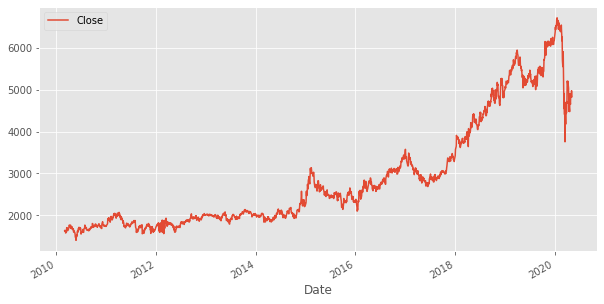

In [9]:
# Import pandas
import pandas as pd
import pandas_datareader as dr
# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Read the data
data = dr.get_data_yahoo('LKOH.ME')
data.index = pd.to_datetime(data.index, dayfirst=True)

# Visualise the data
plt.figure(figsize=(10,5))
data['Close'].plot(figsize=(10,5))
plt.legend()
plt.show()

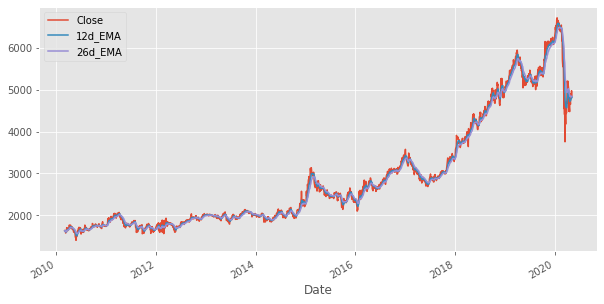

In [10]:
# Calculate exponential moving average
data['12d_EMA'] = data.Close.ewm(span=12).mean()
data['26d_EMA'] = data.Close.ewm(span=26).mean()

data[['Close','12d_EMA','26d_EMA']].plot(figsize=(10,5))
plt.show()

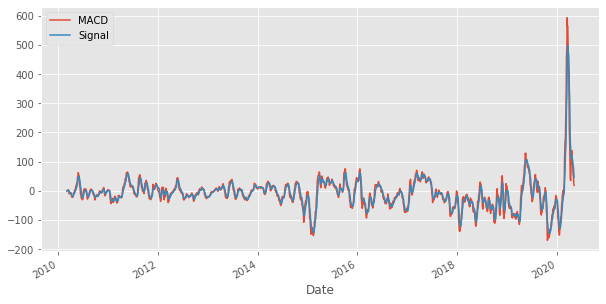

In [11]:
# Calculate MACD
data['MACD'] = data['26d_EMA'] - data['12d_EMA']

# Calculate Signal
data['Signal'] = data.MACD.ewm(span=9).mean()

data[['MACD','Signal']].plot(figsize=(10,5))
plt.show()

In [12]:
# Import numpy
import numpy as np

# Define Signal
data['trading_signal'] = np.where(data['MACD'] > data['Signal'], 1, -1)

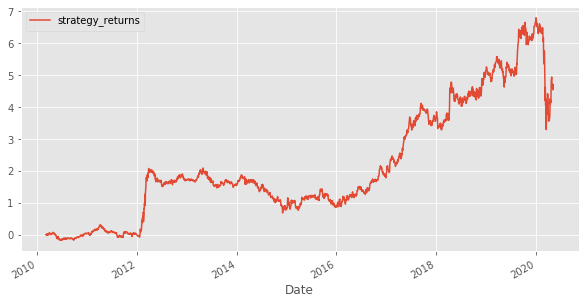

In [13]:
# Calculate Returns
data['returns'] = data.Close.pct_change()

# Calculate Strategy Returns
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

# Calculate Cumulative Returns
cumulative_returns = (data.strategy_returns + 1).cumprod()-1

# Plot Strategy Returns
cumulative_returns.plot(figsize=(10,5))
plt.legend()
plt.show()

In [14]:
stock_name = 'LKOH'

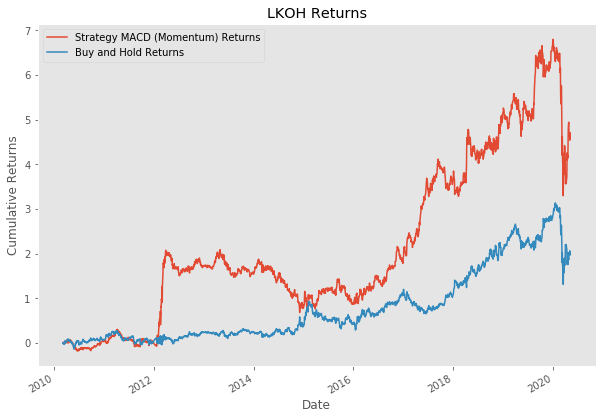

In [15]:
plt.figure(figsize=(10, 7))
# Calculate the cumulative strategy returns and plot
cumulative_returns.plot()
# Calculate the cumulative buy and hold strategy returns
((data.returns+1).cumprod()-1).plot()
# Set the title, label and grid
plt.title(stock_name + ' Returns')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Strategy MACD (Momentum) Returns', 'Buy and Hold Returns'])
plt.grid()
plt.show()

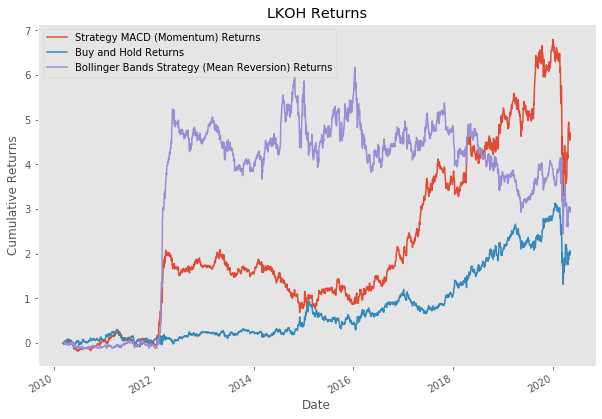

In [16]:
plt.figure(figsize=(10, 7))
# Calculate the cumulative strategy returns and plot
cumulative_returns.plot()
# Calculate the cumulative buy and hold strategy returns
((data.returns+1).cumprod()-1).plot()
#BB strategy
data_LKOH['cumpnl'].plot()
# Set the title, label and grid
plt.title(stock_name + ' Returns')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Strategy MACD (Momentum) Returns', 'Buy and Hold Returns', 'Bollinger Bands Strategy (Mean Reversion) Returns'])
plt.grid()
plt.show()

In [17]:
### Annualised Return or Compound Annual Growth Rate (CAGR)
# Total number of trading days in a year is 252
trading_days = 252

# Calculate CAGR by multiplying the average daily returns with number of trading days
annual_returns = ((1 + data.returns.mean())**(trading_days) - 1)*100

print('The CAGR is %.2f%%' % annual_returns)

### Annualised Volatility
# Calculate the annualised volatility
annual_volatility = data.returns.std() * np.sqrt(trading_days) * 100
print('The annualised volatility is %.2f%%' % annual_volatility)

### Sharpe ratio
# Assume the annual risk-free rate is 6%
risk_free_rate = 0.06
daily_risk_free_return = risk_free_rate/trading_days

# Calculate the excess returns by subtracting the daily returns by daily risk-free return
excess_daily_returns = data.returns - daily_risk_free_return

# Calculate the sharpe ratio using the given formula
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(trading_days)
print('The Sharpe ratio is %.2f' % sharpe_ratio)

The CAGR is 16.85%
The annualised volatility is 30.82%
The Sharpe ratio is 0.31


In [18]:
portfolio_MACD = pd.DataFrame(data['strategy_returns'])

C:\Users\2\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Start date,2010-03-03
End date,2020-05-08
Total months,121
,Backtest
Annual return,18.8%
Cumulative returns,470.1%
Annual volatility,30.8%
Sharpe ratio,0.71
Calmar ratio,0.41
Stability,0.80
Max drawdown,-45.5%


C:\Users\2\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.54,2013-04-29,2014-12-03,2016-11-16,928
1,44.92,2020-01-03,2020-03-18,NaT,NaN
2,29.71,2011-04-07,2011-09-21,2012-02-06,218
3,23.38,2010-04-26,2010-06-16,2011-02-02,203
4,18.49,2012-03-26,2012-07-05,2013-04-29,286


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.29%,-4.98%,3.40%
Fukushima,0.39%,-2.55%,2.56%
EZB IR Event,-0.07%,-3.12%,2.14%
Flash Crash,-1.00%,-3.41%,1.64%
Apr14,0.10%,-1.60%,2.34%
Oct14,-0.06%,-3.16%,2.75%
Fall2015,0.21%,-4.51%,3.96%
Recovery,0.17%,-17.59%,18.50%
New Normal,0.06%,-18.65%,15.42%


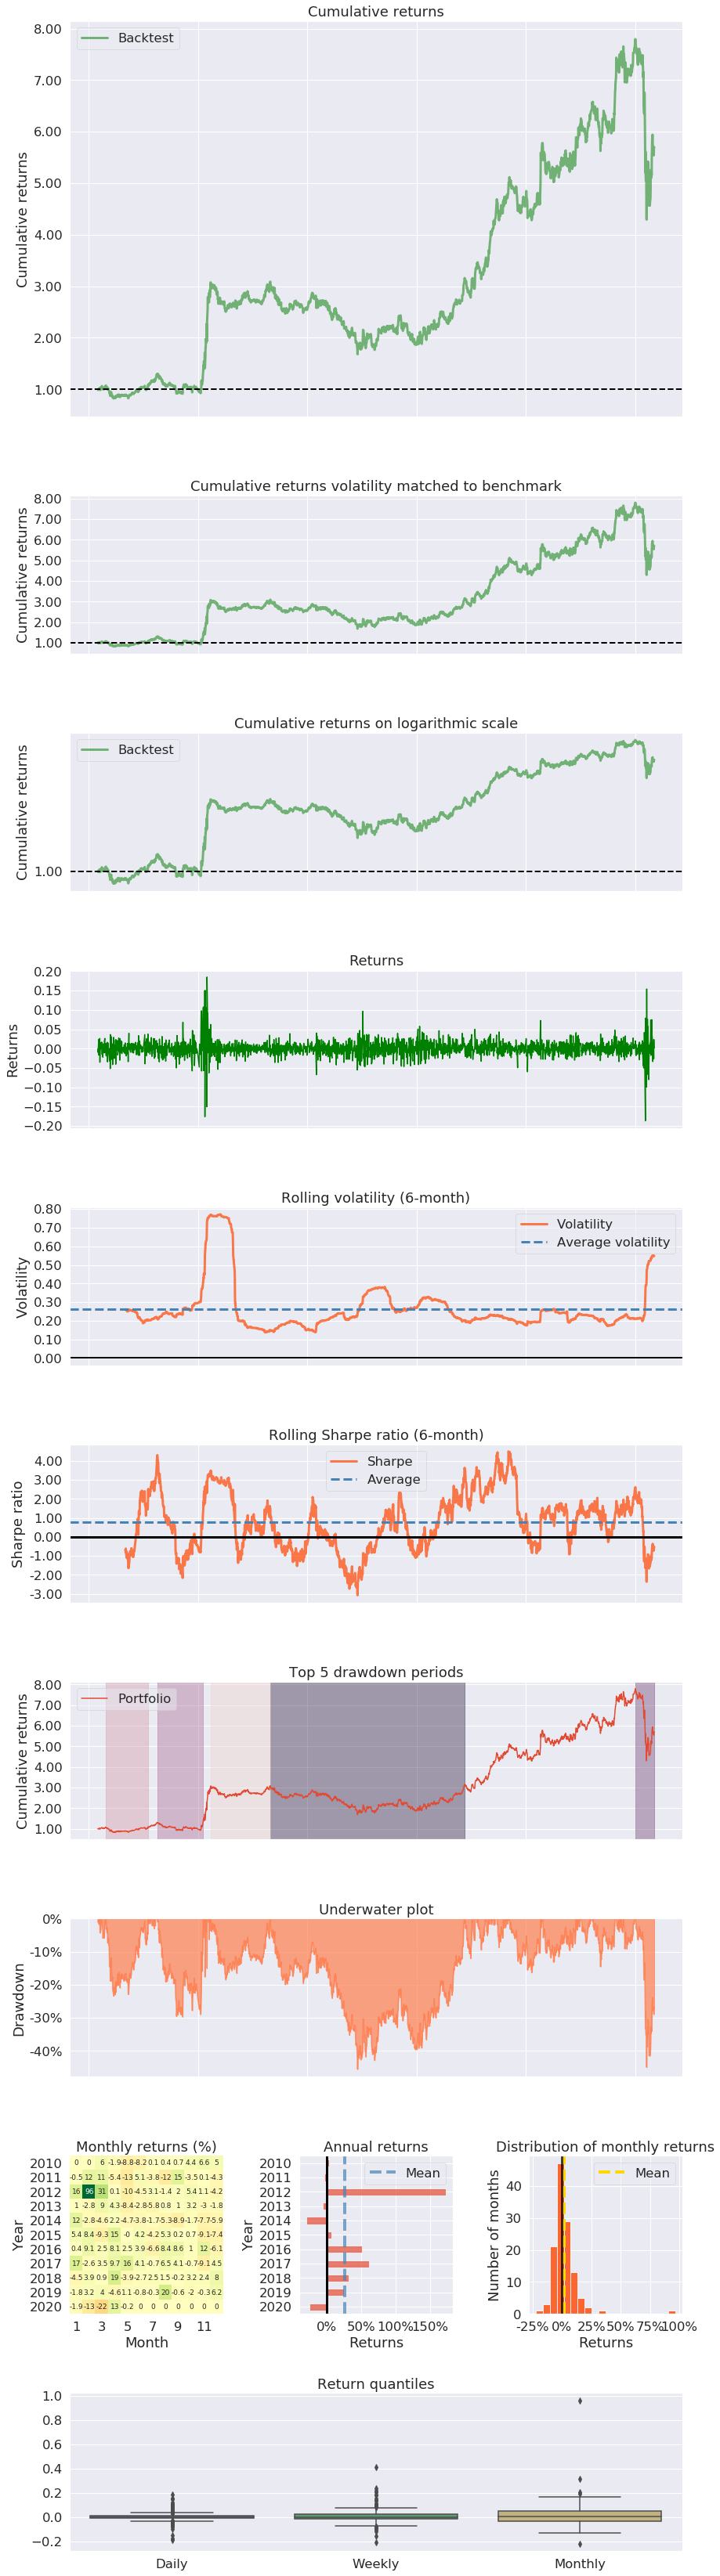

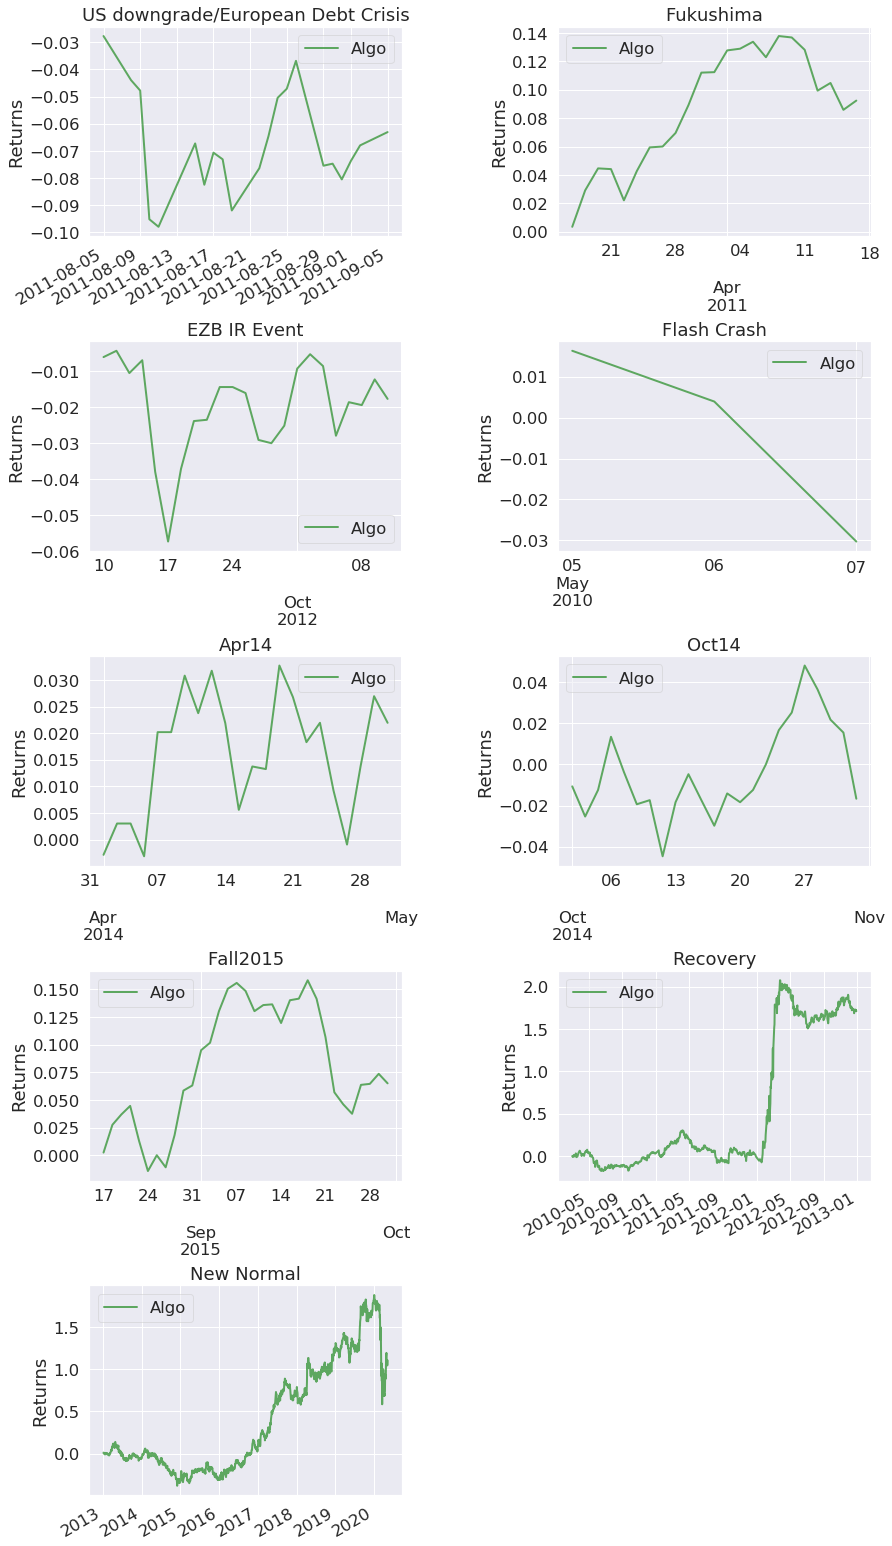

In [19]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio_MACD.mean(axis=1))

# XGBoost block

In [ ]:
!pip install xgboost

In [1]:
# Import warnings and add a filter to ignore them
import warnings
warnings.simplefilter('ignore')
# Import XGBoost
import xgboost
# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn
# For data manipulation
import pandas as pd
import numpy as np

In [4]:
#Define parameters
# Set the stock list
stock_list = ['LKOH.ME']
# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2020-4-17'

We define a list of predictors from which the model will pick the best predictors. Here, we have the percentage change and the standard deviation with different time periods as the predictor variables. 

The target variable is the next day's return. If the next day’s return is positive we label it as 1 and if it is negative then we label it as -1. You can also try to create the target variables with three labels such as 1, 0 and -1 for long, no position and short.

In [6]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}
for stock_name in stock_list:
    # Get the data
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))
    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    df = df.dropna()
    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

Before we move on to the implementation of the XGBoost python model, let’s first plot the daily returns of Apple stored in the dictionary to see if everything is working fine.

In [7]:
stock_data_dictionary

{'CBOM.ME':                High      Low     Open    Close       Volume  Adj Close  \
 Date                                                                     
 2015-09-16  3.62718  3.62718  3.62718  3.62718      14025.0   3.560392   
 2015-09-17  3.60241  3.60241  3.60241  3.60241      27849.0   3.536078   
 2015-09-18  3.63709  3.63709  3.63709  3.63709        100.0   3.570120   
 2015-09-21  3.62768  3.62718  3.62768  3.62718      10292.0   3.560392   
 2015-09-22  3.61727  3.61232  3.61727  3.61281      14025.0   3.546287   
 2015-09-23  3.62718  3.62669  3.62669  3.62718      27849.0   3.560392   
 2015-09-24  3.65691  3.62718  3.65691  3.62718      28959.0   3.560392   
 2015-09-25  3.63263  3.63214  3.63214  3.63263      30372.0   3.565742   
 2015-09-28  3.67376  3.64700  3.67327  3.64700      23409.0   3.579847   
 2015-09-29  3.65691  3.65691  3.65691  3.65691        201.0   3.589575   
 2015-09-30  3.67079  3.66682  3.66682  3.67079        605.0   3.603199   
 2015-10-01  3

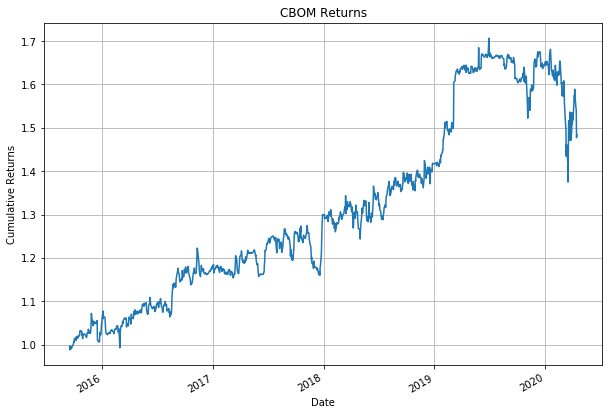

In [9]:
# Set the figure size
plt.figure(figsize=(10, 7))
# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['LKOH.ME'].daily_pct_change+1).cumprod().plot()
# Set the title and axis labels and plot grid
plt.title('LKOH Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

Split the data into train and test.
Since XGBoost is after all a machine learning model, we will split the data set into test and train set.

In [10]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [23]:
stock_data_dictionary[stock_name]

,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,pct_change_10,std_10,pct_change_15,...,pct_change_45,std_45,pct_change_50,std_50,pct_change_55,std_55,return_next_day,actual_signal,predicted_signal,strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-16,3.62718,3.62718,3.62718,3.62718,14025.0,3.560392,-0.005435,0.005595,0.005044,0.009741,...,0.001565,0.003899,0.003345,0.003701,-0.004957,0.004269,-0.006829,-1,-1,0.006829
2015-09-17,3.60241,3.60241,3.60241,3.60241,27849.0,3.536078,-0.006829,-0.003981,0.005473,-0.002606,...,-0.010873,0.003935,-0.003757,0.003827,-0.002411,0.004179,0.009627,1,1,0.009627
2015-09-18,3.63709,3.63709,3.63709,3.63709,100.0,3.570120,0.009627,0.005096,0.006333,0.005651,...,0.000659,0.004192,0.005870,0.004066,0.009547,0.004365,-0.002725,-1,1,-0.002725
2015-09-21,3.62768,3.62718,3.62768,3.62718,10292.0,3.560392,-0.002725,0.007027,0.006185,0.004159,...,-0.000567,0.004206,0.001912,0.004082,-0.002250,0.004207,-0.003962,-1,1,-0.003962
2015-09-22,3.61727,3.61232,3.61727,3.61281,14025.0,3.546287,-0.003962,0.002929,0.006360,0.000746,...,-0.008214,0.004207,-0.001503,0.004121,0.004414,0.003986,0.003978,1,1,0.003978
2015-09-23,3.62718,3.62669,3.62669,3.62718,27849.0,3.560392,0.003978,0.000303,0.006121,0.005684,...,-0.002332,0.004244,0.001654,0.004158,0.003434,0.003966,0.000000,-1,1,0.000000
2015-09-24,3.65691,3.62718,3.65691,3.62718,28959.0,3.560392,0.000000,0.006998,0.005652,0.002937,...,-0.003968,0.004236,-0.003955,0.004079,0.003161,0.003966,0.001503,1,1,0.001503
2015-09-25,3.63263,3.63214,3.63214,3.63263,30372.0,3.565742,0.001503,0.008501,0.005651,0.003889,...,-0.000832,0.004236,-0.000548,0.004077,0.004663,0.003971,0.003956,1,1,0.003956
2015-09-28,3.67376,3.64700,3.67327,3.64700,23409.0,3.579847,0.003956,0.008332,0.005640,0.012501,...,0.001897,0.004274,0.004907,0.004109,0.007386,0.004002,0.002717,1,1,0.002717


Initialising the XGBoost machine learning model.
We will initialize the classifier model. We will set two hyperparameters namely max_depth and n_estimators. These are set on the lower side to reduce overfitting.

In [11]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=2,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=30, n_jobs=None, num_parallel_tree=None,
       objective='binary:logistic', random_state=None, reg_alpha=None,
       reg_lambda=None, scale_pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None)

Cross Validation in Train dataset

In [12]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 52.99% (3.19%)


### Train the model

We will train the XGBoost classifier using the fit method.

In [13]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=30, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

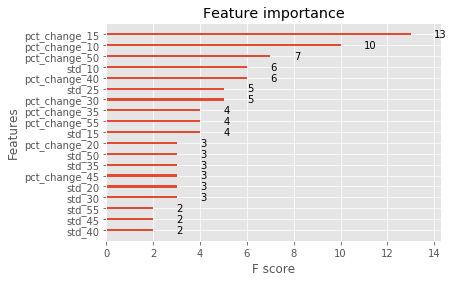

In [96]:
# Plot the top 7 features
xgboost.plot_importance(model)
# Show the plot
plt.show()

### Predict and Classification report

In [15]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.54      0.41      0.46       118
           1       0.51      0.64      0.56       113

   micro avg       0.52      0.52      0.52       231
   macro avg       0.52      0.52      0.51       231
weighted avg       0.52      0.52      0.51       231



### Confusion Matrix

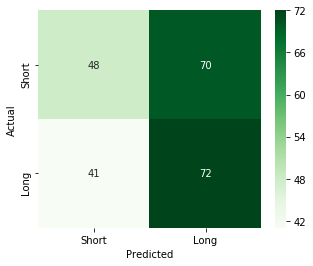

In [16]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Individual stock performance

Let’s see how the XGBoost based strategy returns held up against the normal daily returns ie the buy and hold strategy. We will plot a comparison graph between the strategy returns and the daily returns for all the companies we had mentioned before. The code is as follows:

CBOM.ME


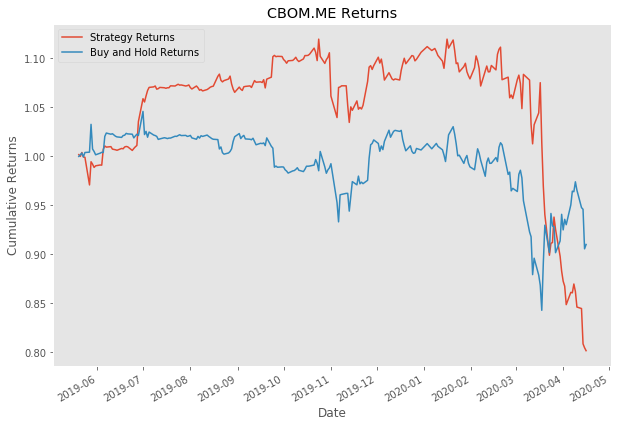

In [77]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    # Set the figure size
    plt.figure(figsize=(10, 7))
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

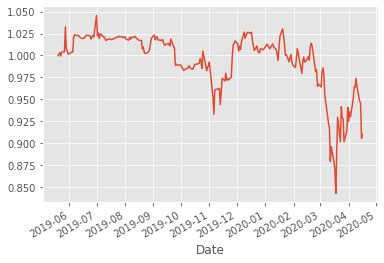

In [80]:
(stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()

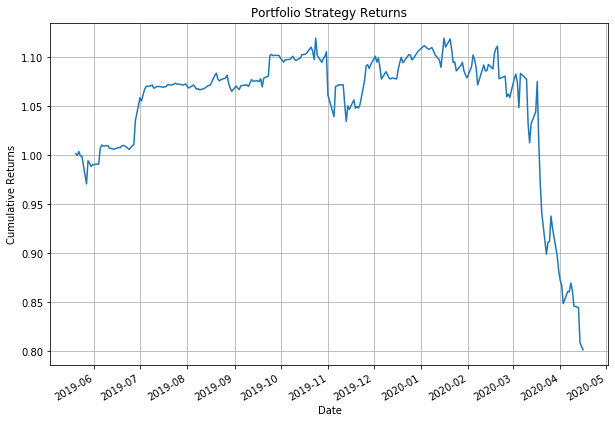

In [18]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [64]:
!pip install pyfolio

  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp37-none-any.whl size=88684 sha256=a9d776adb865ea244c53de21746ada853552efe3d0c2bd4d598e2e19b044432e
  Stored in directory: C:\Users\2\AppData\Local\pip\Cache\wheels\0d\a8\7d\ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.3-cp37-none-any.whl size=37106 sha256=d291e85cebac1b540838da20e3c2147e0c4504eba10cb1ef3972a82740db6af3
  Stored in directory: C:\Users\2\AppData\Local\pip\Cache\wheels\10\a4\3b\951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built pyfolio empyrical


C:\Users\2\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Start date,2016-11-22
End date,2020-01-27
Total months,38
,Backtest
Annual return,39.4%
Cumulative returns,186.6%
Annual volatility,18.3%
Sharpe ratio,1.91
Calmar ratio,1.87
Stability,0.96
Max drawdown,-21.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.14,2018-08-31,2018-11-09,2019-01-25,106
1,14.53,2019-05-02,2019-08-02,2019-10-24,126
2,9.00,2018-03-09,2018-03-29,2018-04-16,27
3,7.46,2017-11-24,2017-12-29,2018-01-19,41
4,5.92,2017-06-07,2017-06-30,2017-07-17,29


Stress Events,mean,min,max
New Normal,0.14%,-6.78%,5.55%


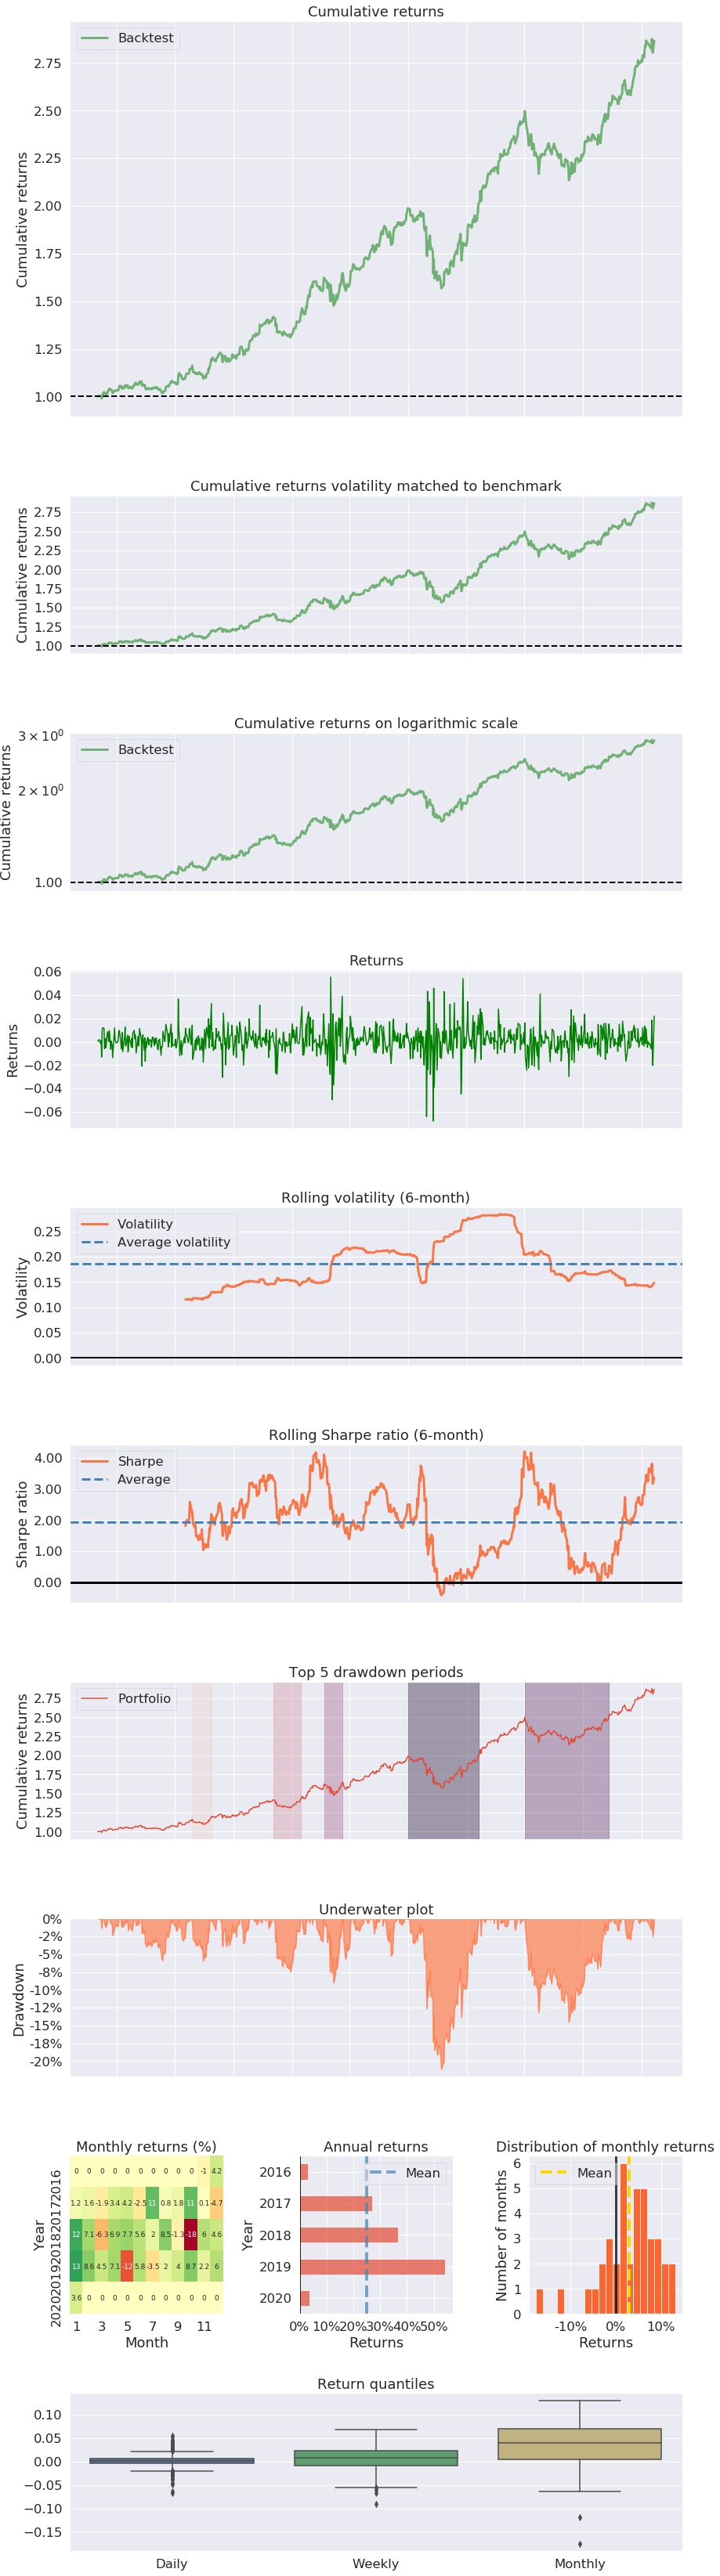

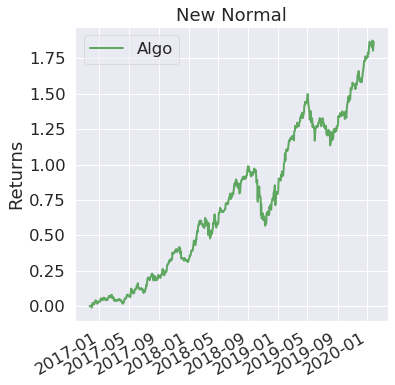

In [65]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))

# XGBoost boooost ???

In [101]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader as dr

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 4                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [102]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [103]:
#Define parameters
# Set the stock list
stock_list = ['LKOH.ME']
# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2020-4-17'

In [ ]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [ ]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

In [ ]:
stock_data_dictionary[stock_name]

In [ ]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

In [ ]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model.fit(X_train, y_train)

In [ ]:
# Plot the top 7 features
xgboost.plot_importance(model)
# Show the plot
plt.show()

In [ ]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

In [ ]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    # Set the figure size
    plt.figure(figsize=(10, 7))
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['XGBoost Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

In [ ]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))